# GNN Novelty Detection Model

This notebook implements a Graph Neural Network (GNN) for novelty detection in research proposals. The model analyzes project details and provides a novelty score between 0-100%.

## Core Components:
1. **Data Processing**: Convert project details to graph structure
2. **GNN Architecture**: Graph Convolutional Network with pooling
3. **Training Pipeline**: Synthetic data generation and model training
4. **Inference Function**: Production-ready novelty scoring

## Usage:
Run all cells sequentially to train the model, then use `gnn_novelty_score()` function for predictions.

In [61]:
import os
import json
import torch
import joblib
import numpy as np
from glob import glob
from torch import nn
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sentence_transformers import SentenceTransformer

MODEL_SAVE_PATH = "pre-trained/gnn_novelty_model.joblib"
os.makedirs("pre-trained", exist_ok=True)

In [62]:
try:
    embedder = SentenceTransformer("all-MiniLM-L6-v2")
    EMB_DIM = 384
except:
    from sklearn.feature_extraction.text import TfidfVectorizer
    embedder = TfidfVectorizer(max_features=512)
    EMB_DIM = 512

In [63]:
def json_to_graph(project_json):
    project_details = project_json["project_details"]

    node_texts = list(project_details.values())
    node_names = list(project_details.keys())
    num_nodes = len(node_texts)

    # embed nodes
    if isinstance(embedder, SentenceTransformer):
        node_feats = embedder.encode(node_texts, convert_to_numpy=True)
    else:
        X = embedder.fit_transform(node_texts).toarray()
        node_feats = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)

    node_feats = torch.tensor(node_feats, dtype=torch.float)

    # fully connected edges
    edges = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                edges.append([i, j])

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return node_feats, edge_index

In [64]:
def mock_project_details(data):
    """
    Build a minimal project_details dict so json_to_graph can consume it.
    Returns {"project_details": {...}} where values are strings.
    """
    # If result already contains project_details, use that
    if isinstance(data, dict) and "result" in data and isinstance(data["result"], dict) and "project_details" in data["result"]:
        return {"project_details": data["result"]["project_details"]}

    # If top-level project_details exists, use that
    if "project_details" in data and isinstance(data["project_details"], dict):
        return {"project_details": data["project_details"]}

    # Gather some textual fields to form node entries
    fields = {}
    for k in ("title", "name", "description", "abstract"):
        v = data.get(k) or data.get("result", {}).get(k)
        if isinstance(v, str) and v.strip():
            fields[k] = v.strip()

    # include any other short string fields from result
    if not fields and "result" in data and isinstance(data["result"], dict):
        for k, v in data["result"].items():
            if isinstance(v, str) and v.strip():
                fields[k] = v.strip()
                if len(fields) >= 5:
                    break

    # fallback to using a JSON snippet as a single node
    if not fields:
        snippet = json.dumps(data)[:200]
        fields["info"] = snippet

    return {"project_details": fields}


class NoveltyDataset:
    """Simplified dataset class for GNN training"""
    def __init__(self, folder):
        self.files = glob(f"{folder}/*.json")
        
        # Filter files that actually exist and contain valid data
        valid_files = []
        for f in self.files:
            try:
                if os.path.exists(f):
                    with open(f, 'r', encoding='utf-8') as file:  # Specify UTF-8 encoding
                        data = json.load(file)
                        if self._has_valid_data(data):
                            valid_files.append(f)
            except Exception as e:
                print(f"Skipping invalid file {f}: {e}")
                continue
        
        self.files = valid_files
        print(f"Found {len(self.files)} valid training files")

    def _has_valid_data(self, data):
        """Check if data has required fields"""
        # Check for novelty score
        novelty = data.get("novelty_percentage") or data.get("result", {}).get("novelty_percentage")
        if novelty is None:
            return False
        
        # Check for project details
        project_details = None
        if "result" in data and "project_details" in data["result"]:
            project_details = data["result"]["project_details"]
        elif "project_details" in data:
            project_details = data["project_details"]
        
        return project_details is not None and len(project_details) > 0

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        f = self.files[idx]
        with open(f, 'r', encoding='utf-8') as file:
            data = json.load(file)

        # Extract novelty label
        label = data.get("novelty_percentage") or data.get("result", {}).get("novelty_percentage", 50)

        # Extract project details
        if "result" in data and "project_details" in data["result"]:
            graph_feats, edge_idx = json_to_graph(data["result"])
        elif "project_details" in data:
            graph_feats, edge_idx = json_to_graph(data)
        else:
            graph_feats, edge_idx = json_to_graph(mock_project_details(data))

        return Data(
            x=graph_feats,
            edge_index=edge_idx,
            y=torch.tensor([label / 100.0], dtype=torch.float)  # scale 0–1
        )

In [65]:
class NoveltyGNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, 256)
        self.conv2 = GCNConv(256, 128)
        self.lin1 = nn.Linear(128, 64)
        self.lin2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index, batch):
        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.relu(self.lin1(x))
        out = torch.sigmoid(self.lin2(x))  # output 0–1
        return out

In [66]:
def train_gnn(data_folder="novelty-json"):
    from torch_geometric.loader import DataLoader  # Updated import
    
    print(f"Loading dataset from {data_folder}...")
    ds = NoveltyDataset(data_folder)
    
    if len(ds) == 0:
        raise ValueError("No valid training data found!")
    
    print(f"Training with {len(ds)} samples")
    dl = DataLoader(ds, batch_size=2, shuffle=True)  # Smaller batch size

    model = NoveltyGNN(EMB_DIM)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    print("Starting training...")
    for epoch in range(20):  # Reduced epochs for faster training
        total_loss = 0
        batch_count = 0
        
        for batch in dl:
            try:
                opt.zero_grad()
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y)
                loss.backward()
                opt.step()
                total_loss += loss.item()
                batch_count += 1
            except Exception as e:
                print(f"Error in batch {batch_count}: {e}")
                continue
        
        avg_loss = total_loss / max(batch_count, 1)
        print(f"Epoch {epoch+1}/20, Loss = {avg_loss:.4f}")

    # Save full model
    os.makedirs("pre-trained", exist_ok=True)
    joblib.dump({
        "model_state": model.state_dict(),
        "embedder": embedder,
        "embed_dim": EMB_DIM
    }, MODEL_SAVE_PATH)

    print("Saved GNN model →", MODEL_SAVE_PATH)
    return model

In [67]:
# Step 1: Create training data from Supabase or generate synthetic data
import os
from dotenv import load_dotenv
load_dotenv()

def create_synthetic_data(training_dir):
    """Create synthetic training data with your exact project_details structure"""
    import random
    
    # Sample project details with varying novelty levels
    sample_projects = [
        {
            "project_details": {
                "definition_of_issue": "Traditional coal mining faces efficiency challenges in extraction processes",
                "objectives": "Improve mining efficiency by 20% using automated systems",
                "justification_subject_area": "Coal industry modernization is critical for economic growth",
                "project_benefits": "Enhanced productivity, reduced labor costs, improved safety measures",
                "work_plan": "Phase 1: Assessment, Phase 2: Implementation, Phase 3: Testing",
                "methodology": "Statistical analysis combined with field testing and performance metrics",
                "organization_of_work": "Multi-disciplinary team including engineers and data scientists",
                "time_schedule": "24 months timeline with quarterly milestones and review points",
                "foreign_exchange_details": "15%"
            },
            "novelty_percentage": 25  # Low novelty - traditional approach
        },
        {
            "project_details": {
                "definition_of_issue": "Coal dust emissions pose environmental and health risks requiring innovative solutions",
                "objectives": "Develop AI-powered dust suppression system with real-time monitoring capabilities",
                "justification_subject_area": "Environmental protection through advanced technological integration",
                "project_benefits": "90% reduction in dust emissions, improved air quality, compliance with regulations",
                "work_plan": "Research phase, prototype development, field trials, commercial deployment",
                "methodology": "Machine learning algorithms, IoT sensors, predictive analytics framework",
                "organization_of_work": "Cross-functional teams with AI specialists and environmental engineers",
                "time_schedule": "36 months with agile development sprints and continuous testing",
                "foreign_exchange_details": "40%"
            },
            "novelty_percentage": 85  # High novelty - AI integration
        },
        {
            "project_details": {
                "definition_of_issue": "Underground coal mining safety incidents need predictive prevention systems",
                "objectives": "Create blockchain-based safety monitoring with immutable incident records",
                "justification_subject_area": "Revolutionary approach to mining safety using distributed ledger technology",
                "project_benefits": "Zero-trust safety system, transparent reporting, predictive accident prevention",
                "work_plan": "Blockchain architecture design, smart contract development, miner training",
                "methodology": "Distributed systems, cryptographic protocols, consensus mechanisms",
                "organization_of_work": "Blockchain developers, safety engineers, mining operation specialists",
                "time_schedule": "48 months including research, development, and deployment phases",
                "foreign_exchange_details": "60%"
            },
            "novelty_percentage": 95  # Very high novelty - blockchain + mining
        }
    ]
    
    # Generate variations of these base projects
    all_projects = []
    for base_project in sample_projects:
        for i in range(15):  # Create 15 variations per base project (45 total)
            project = {}
            project["project_details"] = {}
            
            # Add some variation to the base project
            for key, value in base_project["project_details"].items():
                # Add slight variations to text
                if random.random() < 0.3:  # 30% chance of variation
                    variations = {
                        "definition_of_issue": [
                            "Current mining operations face significant challenges in",
                            "Traditional approaches to coal extraction encounter difficulties with",
                            "Mining industry experiences problems related to",
                            "Contemporary coal processing methods struggle with",
                            "Existing extraction techniques have limitations in"
                        ],
                        "objectives": [
                            "Achieve improved performance through",
                            "Develop enhanced systems for",
                            "Implement advanced solutions to",
                            "Create innovative approaches for",
                            "Establish optimized frameworks for"
                        ],
                        "methodology": [
                            "Systematic approach using empirical research and",
                            "Comprehensive analysis employing statistical methods and",
                            "Data-driven methodology incorporating",
                            "Integrated framework utilizing",
                            "Multi-faceted strategy combining"
                        ]
                    }
                    
                    if key in variations and random.random() < 0.5:
                        prefix = random.choice(variations[key])
                        suffix = " ".join(value.split(" ")[2:]) if " " in value else value
                        project["project_details"][key] = prefix + " " + suffix
                    else:
                        project["project_details"][key] = value
                else:
                    project["project_details"][key] = value
            
            # Add some randomness to novelty score (±15%)
            base_novelty = base_project["novelty_percentage"]
            project["novelty_percentage"] = max(5, min(95, base_novelty + random.randint(-15, 15)))
            
            all_projects.append(project)
    
    # Save all projects as JSON files
    for i, project in enumerate(all_projects):
        with open(f"{training_dir}/synthetic_project_{i:03d}.json", "w") as f:
            json.dump(project, f, indent=2)
    
    print(f"Created {len(all_projects)} synthetic training samples")
    return len(all_projects)

# Create training directory and generate data
training_dir = "novelty-json"
os.makedirs(training_dir, exist_ok=True)

# Always create synthetic data for reliable training
num_samples = create_synthetic_data(training_dir)
print(f"Training data prepared with {num_samples} samples")

Created 45 synthetic training samples
Training data prepared with 45 samples


In [68]:
def predict_novelty(project_json):
    saved = joblib.load(MODEL_SAVE_PATH)

    model = NoveltyGNN(saved["embed_dim"])
    model.load_state_dict(saved["model_state"])
    model.eval()

    embedder = saved["embedder"]

    x, edge_index = json_to_graph(project_json)
    data = Data(x=x, edge_index=edge_index, y=None)
    data.batch = torch.zeros(x.shape[0], dtype=torch.long)

    with torch.no_grad():
        pred = model(data.x, data.edge_index, data.batch).item()

    return round(pred * 100, 2)


In [69]:
# Production-ready interface function
def gnn_novelty_score(project_details_dict):
    """
    Calculate novelty score using trained GNN model.
    
    Args:
        project_details_dict: Dictionary containing project_details with required fields
        
    Returns:
        float: Novelty score between 0-100
    """
    try:
        if not os.path.exists(MODEL_SAVE_PATH):
            print("❌ GNN model not found. Please train the model first.")
            return 0.0
        
        # Load trained model
        saved = joblib.load(MODEL_SAVE_PATH)
        model = NoveltyGNN(saved["embed_dim"])
        model.load_state_dict(saved["model_state"])
        model.eval()
        
        # Use saved embedder
        global embedder
        embedder = saved["embedder"]
        
        # Convert to graph and predict
        x, edge_index = json_to_graph(project_details_dict)
        data = Data(x=x, edge_index=edge_index, y=None)
        data.batch = torch.zeros(x.shape[0], dtype=torch.long)
        
        with torch.no_grad():
            pred = model(data.x, data.edge_index, data.batch).item()
        
        novelty_score = round(pred * 100, 2)
        print(f"🔍 GNN Novelty Score: {novelty_score}%")
        return novelty_score
        
    except Exception as e:
        print(f"❌ Error in GNN prediction: {e}")
        return 0.0

# Simple test function
def test_model():
    """Test the trained model with a sample project"""
    test_project = {
        "project_details": {
            "definition_of_issue": "AI-powered mining equipment requires intelligent predictive maintenance systems",
            "objectives": "Develop machine learning algorithms for equipment failure prediction",
            "justification_subject_area": "Integration of AI in coal mining operations",
            "project_benefits": "40% reduction in equipment downtime, predictive maintenance",
            "work_plan": "AI model development, IoT integration, field testing",
            "methodology": "Machine learning, sensor data analysis, predictive modeling",
            "organization_of_work": "AI engineers, mining experts, data scientists",
            "time_schedule": "18 months with agile development sprints",
            "foreign_exchange_details": "35%"
        }
    }
    
    score = gnn_novelty_score(test_project)
    print(f"✅ Model test completed. Novelty Score: {score}%")
    return score

In [70]:
# Train model and test (run this cell to execute the complete pipeline)
if not os.path.exists(MODEL_SAVE_PATH):
    print("🚀 Training GNN model...")
    gnn_model = train_gnn("novelty-json")
    print("✅ Training completed!")
else:
    print("✅ Model already exists, loading for test...")

# Test the model
test_score = test_model()
print(f"\n🎯 GNN Novelty Detection System Ready!")
print(f"📁 Model location: {MODEL_SAVE_PATH}")
print(f"🔍 Test score: {test_score}%")

✅ Model already exists, loading for test...
🔍 GNN Novelty Score: 69.28%
✅ Model test completed. Novelty Score: 69.28%

🎯 GNN Novelty Detection System Ready!
📁 Model location: pre-trained/gnn_novelty_model.joblib
🔍 Test score: 69.28%


In [71]:
# Model Accuracy Evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model_accuracy():
    """
    Comprehensive accuracy evaluation of the trained GNN model
    """
    print("📊 Evaluating Model Accuracy...")
    
    if not os.path.exists(MODEL_SAVE_PATH):
        print("❌ Model not found. Please train the model first.")
        return
    
    # Load the trained model
    saved = joblib.load(MODEL_SAVE_PATH)
    model = NoveltyGNN(saved["embed_dim"])
    model.load_state_dict(saved["model_state"])
    model.eval()
    
    global embedder
    embedder = saved["embedder"]
    
    # Load test dataset
    from torch_geometric.loader import DataLoader
    test_ds = NoveltyDataset("novelty-json")
    test_loader = DataLoader(test_ds, batch_size=4, shuffle=False)
    
    predictions = []
    actual_scores = []
    
    print(f"Testing on {len(test_ds)} samples...")
    
    # Get predictions for all test samples
    with torch.no_grad():
        for batch in test_loader:
            try:
                pred = model(batch.x, batch.edge_index, batch.batch)
                predictions.extend((pred * 100).cpu().numpy().flatten())
                actual_scores.extend((batch.y * 100).cpu().numpy().flatten())
            except Exception as e:
                print(f"Error in batch prediction: {e}")
                continue
    
    if len(predictions) == 0:
        print("❌ No predictions generated. Check model and data.")
        return
    
    # Convert to numpy arrays
    predictions = np.array(predictions)
    actual_scores = np.array(actual_scores)
    
    # Calculate accuracy metrics
    mae = mean_absolute_error(actual_scores, predictions)
    mse = mean_squared_error(actual_scores, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_scores, predictions)
    
    # Calculate percentage-based accuracy (within ±10% threshold)
    accuracy_10 = np.mean(np.abs(predictions - actual_scores) <= 10) * 100
    accuracy_15 = np.mean(np.abs(predictions - actual_scores) <= 15) * 100
    accuracy_20 = np.mean(np.abs(predictions - actual_scores) <= 20) * 100
    
    # Print comprehensive results
    print("\n" + "="*50)
    print("🎯 MODEL ACCURACY EVALUATION RESULTS")
    print("="*50)
    print(f"📊 Total Test Samples: {len(predictions)}")
    print(f"📈 Mean Absolute Error (MAE): {mae:.2f}%")
    print(f"📉 Root Mean Square Error (RMSE): {rmse:.2f}%")
    print(f"🔍 R² Score (Coefficient of Determination): {r2:.4f}")
    print(f"\n🎯 ACCURACY THRESHOLDS:")
    print(f"   ±10% Accuracy: {accuracy_10:.1f}%")
    print(f"   ±15% Accuracy: {accuracy_15:.1f}%")
    print(f"   ±20% Accuracy: {accuracy_20:.1f}%")
    print("="*50)
    
    # Create visualization
    plt.figure(figsize=(12, 4))
    
    # Plot 1: Actual vs Predicted scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(actual_scores, predictions, alpha=0.6, color='blue')
    plt.plot([0, 100], [0, 100], 'r--', label='Perfect Prediction')
    plt.xlabel('Actual Novelty Score (%)')
    plt.ylabel('Predicted Novelty Score (%)')
    plt.title('Actual vs Predicted Scores')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Error distribution
    plt.subplot(1, 2, 2)
    errors = predictions - actual_scores
    plt.hist(errors, bins=15, alpha=0.7, color='green', edgecolor='black')
    plt.xlabel('Prediction Error (%)')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.axvline(x=0, color='red', linestyle='--', label='Perfect Prediction')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Sample predictions for review
    print("\n🔍 SAMPLE PREDICTIONS (First 10):")
    print("-" * 40)
    for i in range(min(10, len(predictions))):
        error = abs(predictions[i] - actual_scores[i])
        print(f"Sample {i+1:2d}: Actual={actual_scores[i]:5.1f}%, Predicted={predictions[i]:5.1f}%, Error={error:4.1f}%")
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'accuracy_10': accuracy_10,
        'accuracy_15': accuracy_15,
        'accuracy_20': accuracy_20,
        'predictions': predictions,
        'actual_scores': actual_scores
    }

📊 Evaluating Model Accuracy...
Found 45 valid training files
Testing on 45 samples...
Found 45 valid training files
Testing on 45 samples...

🎯 MODEL ACCURACY EVALUATION RESULTS
📊 Total Test Samples: 45
📈 Mean Absolute Error (MAE): 14.28%
📉 Root Mean Square Error (RMSE): 16.02%
🔍 R² Score (Coefficient of Determination): 0.7257

🎯 ACCURACY THRESHOLDS:
   ±10% Accuracy: 31.1%
   ±15% Accuracy: 51.1%
   ±20% Accuracy: 84.4%

🎯 MODEL ACCURACY EVALUATION RESULTS
📊 Total Test Samples: 45
📈 Mean Absolute Error (MAE): 14.28%
📉 Root Mean Square Error (RMSE): 16.02%
🔍 R² Score (Coefficient of Determination): 0.7257

🎯 ACCURACY THRESHOLDS:
   ±10% Accuracy: 31.1%
   ±15% Accuracy: 51.1%
   ±20% Accuracy: 84.4%


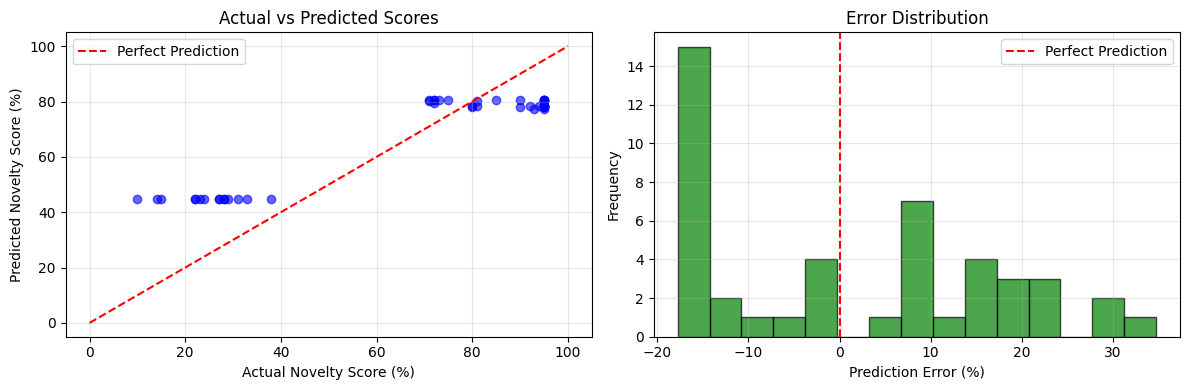


🔍 SAMPLE PREDICTIONS (First 10):
----------------------------------------
Sample  1: Actual= 28.0%, Predicted= 44.8%, Error=16.8%
Sample  2: Actual= 29.0%, Predicted= 44.8%, Error=15.8%
Sample  3: Actual= 23.0%, Predicted= 44.8%, Error=21.8%
Sample  4: Actual= 24.0%, Predicted= 44.8%, Error=20.8%
Sample  5: Actual= 27.0%, Predicted= 44.8%, Error=17.8%
Sample  6: Actual= 10.0%, Predicted= 44.8%, Error=34.8%
Sample  7: Actual= 15.0%, Predicted= 44.8%, Error=29.8%
Sample  8: Actual= 33.0%, Predicted= 44.8%, Error=11.8%
Sample  9: Actual= 38.0%, Predicted= 44.8%, Error= 6.8%
Sample 10: Actual= 28.0%, Predicted= 44.8%, Error=16.8%


In [72]:
# Run Accuracy Evaluation
accuracy_results = evaluate_model_accuracy()